In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataset as dt
from keras.utils import to_categorical
from xtx_model import simple_model, simple_cnn, simple_mlp, get_weight_grad, rate_size_fusion, lstm_fcn, deep_lob
from main import tf_score, score, model_score
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pickle
import copy
import pandas as pd
import warnings
import normlization as dt_norm
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import itertools

Using TensorFlow backend.


## 1. load raw data

#### 1.1 load data

In [44]:
raw_data = dt.load_raw_data()

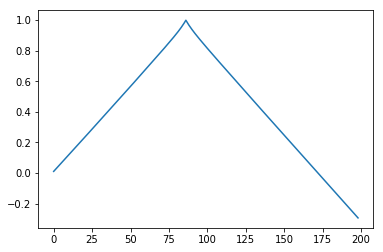

In [89]:
y = raw_data[:, 60]

mid_price = (raw_data[:, 0] + raw_data[:, 30]) / 2

scores = []
for n in range(1, 200):
    mid_price_diff = mid_price[n:] - mid_price[:-n]
    scores.append(score(y[:-n], mid_price_diff))
plt.plot(scores)

In [8]:
%%time
ds = []
ys = []
for i in range(68, 68+256):
    _d, _y = dt.slide_norm_data_func(dataset.raw_data, i)
    ds.append(_d)
    ys.append(_y)
ds = np.array(ds)
ys = np.array(ys)

Wall time: 85.9 ms


#### 1.2 plot raw data distribution

In [ ]:
train_data = raw_data[:400000:10]
test_data = raw_data[-400000::10]

In [ ]:
dt.train_test_plot(train_data[:,60], test_data[:,60], title='label CM-distribution')

In [ ]:
dt.train_test_plot(train_data[:, 0], test_data[:, 0], title='AskRate0 CM-distribution')

## 2. data pre-processing

#### 2.1 whitening

In [ ]:
train_data = np.copy(raw_data[:400000:10, 0])
test_data = np.copy(raw_data[-400000::10, 0])

train_mean = np.mean(train_data)
train_std = np.std(train_data)
train_data = (train_data - train_mean) / train_std
test_mean = np.mean(test_data)
test_std = np.std(test_data)
test_data = (test_data - test_mean) / test_std

dt.train_test_plot(train_data, test_data)

In [ ]:
raw_diff = np.diff(raw_data[:2900001, 0]) != 0
raw_diff = np.cumsum(raw_diff)
for k in range(10):
    plt.plot(raw_diff[k*290000:(k+1)*290000] - raw_diff[k*290000], label='{}'.format(k))
plt.legend()
plt.show()

#### 2.1 sliding whitening

In [ ]:
def get_data(window_size=60):
    _train = np.pad(raw_data[:400000], ((window_size-1, 0), (0,0)), 'edge')
    _test = np.pad(raw_data[-400000:], ((window_size-1, 0), (0,0)), 'edge')
    train_x, train_y = dt.data_sliding(_train, time_step=window_size)
    test_x, train_y = dt.data_sliding(_test, time_step=window_size)
    
    train_data = (train_x[:, -1] - np.mean(train_x, axis=1)) / (np.std(train_x, axis=1) + 1e-4)
    test_data = (test_x[:, -1] - np.mean(test_x, axis=1)) / (np.std(test_x, axis=1) + 1e-4)
    return train_data[::10, 0], test_data[::10, 0]

In [ ]:
window_sizes = [30, 60, 120, 240]
plt.subplots(2, 2, figsize=(14,8))
for i, size in enumerate(window_sizes):
    axe = plt.subplot(2, 2, i+1)
    train_data, test_data = get_data(size)
    sns.kdeplot(train_data, cumulative=True, legend=True, ax=axe, label='train')
    sns.kdeplot(test_data, cumulative=True, legend=True, ax=axe, label='test')
    plt.title('window size:{}'.format(size))
plt.show()

#### 2.2 normlization

In [98]:
time_step = 15
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=time_step, norm_window_size=10)

train:359998, val:59999, test:180000


In [ ]:
dt.train_test_plot(train_y[:40000], test_y[:40000], title='label')

# 3. model

In [4]:
# callbacks
checkpoint = ModelCheckpoint('', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, min_delta=1e-4, verbose=1)
train_callbacks = [earlystop, reduce_lr]

### 3.1 lstm

In [ ]:
# lstm
model = simple_model(regression=True)
model.compile(Adam(2e-4), loss=tf_score, metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(val_x, val_y))

In [ ]:
# test
test_y_prob = model.predict(test_x, batch_size=128, verbose=1)
test_y_pred = np.argmax(test_y_pred, axis=1)
sns.distplot(test_y_pred, kde=False)

score(test_y*0.25 - 1.25, test_y_pred_*0.25 - 1.25)

### 3.1.2 lstm_fcn

In [ ]:
time_step = 60
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=time_step, norm_window_size=60)

In [138]:
reg = True
lstm_fcn_model = lstm_fcn(time_step=time_step, regression=reg)
loss = 'categorical_crossentropy' if not reg else 'mse'
lstm_fcn_model.compile(Adam(2e-4), loss=loss, metrics=['accuracy'])

In [ ]:
lstm_fcn_model.fit(train_x[::5], train_y[::5], batch_size=256, epochs=20, validation_data=(val_x, val_y))

In [140]:
pred_val_y = lstm_fcn_model.predict(val_x, batch_size=256, verbose=1)
score(val_y, pred_val_y[:, 0])

299998/299998 [==============================] - 6s 21us/step


-0.03799474239349365

### 3.2 cnn

In [ ]:
# cnn
model = simple_cnn()
model.compile(Adam(3e-4), loss=categorical_crossentropy, metrics=['accuracy'])
model.summary()

### 3.3 mlp

In [5]:
# load dataset
dataset = dt.XTXDataset()
dataset.delete_invalid_rows()

Time series length: 2999999


##### max_min normlization

In [70]:
x, y = dt.data_sliding(dataset.raw_data[:,:60], dataset.label_y, time_step=60, time_stride=5)
x = x[::5]
y = y[::5]
max_x = np.max(x, axis=1, keepdims=True)
min_x = np.min(x, axis=1, keepdims=True)
normed_x = (x - min_x) / (max_x - min_x + 1e-3)

In [72]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([normed_x, y], split=[0.6, 0.1, 0.3], sampling=1)

train:359910, val:59985, test:179955


In [121]:
train_x.shape

(359937, 15, 60)

##### z-move-normlization

In [48]:
time_step = 15
wsz = 10
time_stride = 1

In [49]:
normed_data = dt_norm.slide_norm(dataset.features, window_size=wsz)
# padded_features = np.pad(dataset.features, ((wsz-1, 0), (0, 0)), 'edge')
# features = dt.data_sliding(padded_features, time_step=time_step)
# mean_features = np.mean(features, axis=1)
# std_features = np.std(features, axis=1)

middle_price = (dataset.features[:, 0] + dataset.features[:, 30]) / 2
normed_y = 1000 * dataset.label_y / middle_price

x, y = dt.data_sliding(normed_data, dataset.label_y, time_step=time_step*time_stride)
x = x[:, ::time_stride]
# (train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data_by_interval([x, y], split=[0.6, 0.2, 0.2], sampling=5)
# (train_x, train_y, train_mp), (val_x, val_y, val_mp), (test_x, test_y, test_mp) = dt.split_data([x, y, middle_price], split=[0.6, 0.1, 0.3], sampling=5)
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

train:359944, val:59990, test:179973


##### z-move-normlization-v2

In [155]:
time_step = 15
x, y = dt.data_sliding(dataset.features, dataset.label_y, time_step=time_step)

In [156]:
rate = np.concatenate([x[:, :, :15], x[:, :, 30:45]], axis=2)
rate_mean = np.mean(rate, axis=(1, 2), keepdims=True)
rate_std = np.std(rate, axis=(1, 2), keepdims=True)
size = np.concatenate([x[:, :, 15:30], x[:, :, 45:60]], axis=2)
size_mean = np.mean(size, axis=(1, 2), keepdims=True)
size_std = np.std(size, axis=(1, 2), keepdims=True)

In [157]:
normed_rate = (rate - rate_mean) / (rate_std + 1e-4)
normed_size = (size - size_mean) / (size_std + 1e-4)

normed_data = np.concatenate([normed_rate[..., :15], normed_size[..., :15], normed_rate[..., 15:30], normed_size[..., 15:30]], axis=2)

In [158]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([normed_data, y], split=[0.6, 0.1, 0.3], sampling=5)

train:359944, val:59990, test:179973


##### z-move-normlization-v3

In [23]:
time_step = 15
wsz = 10
x, y = dt.data_sliding(dataset.features, dataset.label_y, time_step=wsz)

rate = np.concatenate([x[:, :, :15], x[:, :, 30:45]], axis=2)
rate_mean = np.mean(rate, axis=(1, 2), keepdims=True)
rate_std = np.std(rate, axis=(1, 2), keepdims=True)
size = np.concatenate([x[:, :, 15:30], x[:, :, 45:60]], axis=2)
size_mean = np.mean(size, axis=(1, 2), keepdims=True)
size_std = np.std(size, axis=(1, 2), keepdims=True)

In [24]:
normed_rate = (rate[:, -1, :] - np.squeeze(rate_mean, axis=2)) / (np.squeeze(rate_std, axis=2) + 1e-4)
normed_size = (size[:, -1, :] - np.squeeze(size_mean, axis=2)) / (np.squeeze(size_std, axis=2) + 1e-4)

normed_data = np.concatenate([normed_rate[..., :15], normed_size[..., :15], normed_rate[..., 15:30], normed_size[..., 15:30]], axis=1)

In [25]:
x, y = dt.data_sliding(normed_data, y, time_step=time_step)
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

train:359943, val:59990, test:179972


##### z-move-normlization-by-middle-rate

In [93]:
time_step = 15
wsz = 10

In [97]:
middle_price = (dataset.features[:, 0] + dataset.features[:, 30]) / 2

##### z-global normlization

In [161]:
nb_train_sample = int(dataset.raw_data.shape[0] * 0.7)
train_mean = np.mean(dataset.features, axis=0, keepdims=True)
train_std = np.std(dataset.features, axis=0, keepdims=True)

In [163]:
x = (dataset.features - train_mean) / train_std
x, y = dt.data_sliding(x, dataset.label_y, time_step=time_step)

In [165]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

train:359944, val:59990, test:179973


##### no-z-normalization

In [31]:
time_step = 15
norm_wsz = 10

mid_price = (dataset.features[:, 0] + dataset.features[:, 30]) / 2
n = 87
y = mid_price[n:] - mid_price[:-n]
x = dataset.features[:-n]

x, y = dt.data_sliding(x, y, time_step=time_step+norm_wsz-1)
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

train_valid = train_x.shape[0] // 256 * 256
val_valid = val_x.shape[0] // 256 * 256
train_x = train_x[:train_valid]
train_y = train_y[:train_valid]
val_x = val_x[:val_valid]
val_y = val_y[:val_valid]

train:359932, val:59989, test:179967


##### train model

In [32]:
models = []

In [ ]:
for i in range(25):
    # mlp
    model = simple_mlp(time_step=time_step, regression=True, batch_norm=False)
    model.compile(Adam(2e-4), loss=tf_score, metrics=['accuracy'])
    # model.summary()

    # train & evaluation
    history = model.fit(train_x, train_y, batch_size=256, epochs=20, validation_data=(val_x, val_y), callbacks=train_callbacks)
    models.append(model)
# train_score, val_score, test_score = model_score(model, train_x, train_y, val_x, val_y, test_x, test_y)

In [36]:
for x, y in zip([train_x, val_x, test_x], [train_y, val_y, test_y]):
    preds = []
    for model in models:
        preds.append(model.predict(x, batch_size=256))
    pred_y = np.stack(preds, axis=1)
    print(score(y, np.mean(pred_y, axis=1)))

0.02213585376739502
0.017158091068267822
0.015904366970062256


In [ ]:
batch_size = [256, 512]
leak_relu_alpha = [1e-4, 1e-3, 1e-2, 1e-1, 2e-1, 3e-1]

p = itertools.product(batch_size, leak_relu_alpha)

val_scores = {}
test_scores = {}
for bs, alpha in p:
    model = simple_mlp(time_step=time_step, regression=True, batch_norm=False, leaky_relu_alpha=alpha)
    model.compile(Adam(2e-4), loss=tf_score, metrics=['accuracy'])
    history = model.fit(train_x, train_y, batch_size=bs, epochs=20, validation_data=(val_x, val_y), callbacks=train_callbacks)
    train_score, val_score, test_score = model_score(model, train_x, train_y, val_x, val_y, test_x, test_y)
    
    param = 'batch_size:{}_alpha:{}'.format(bs, alpha)
    val_scores[param] = val_score
    test_scores[param] = test_score

In [36]:
val_scores

{'batch_size:256_alpha:0.0001': 0.01704806089401245,
 'batch_size:256_alpha:0.001': 0.016438663005828857,
 'batch_size:256_alpha:0.01': 0.012787699699401855,
 'batch_size:256_alpha:0.1': 0.016999542713165283,
 'batch_size:256_alpha:0.2': 0.015645503997802734,
 'batch_size:256_alpha:0.3': 0.01658952236175537,
 'batch_size:512_alpha:0.0001': 0.015582144260406494,
 'batch_size:512_alpha:0.001': 0.015358924865722656,
 'batch_size:512_alpha:0.01': 0.014608025550842285,
 'batch_size:512_alpha:0.1': 0.017014503479003906,
 'batch_size:512_alpha:0.2': 0.015494108200073242,
 'batch_size:512_alpha:0.3': 0.016971290111541748}

In [37]:
test_scores

{'batch_size:256_alpha:0.0001': 0.015557169914245605,
 'batch_size:256_alpha:0.001': 0.015375614166259766,
 'batch_size:256_alpha:0.01': 0.013300836086273193,
 'batch_size:256_alpha:0.1': 0.01551741361618042,
 'batch_size:256_alpha:0.2': 0.01420503854751587,
 'batch_size:256_alpha:0.3': 0.01437675952911377,
 'batch_size:512_alpha:0.0001': 0.014170706272125244,
 'batch_size:512_alpha:0.001': 0.014802813529968262,
 'batch_size:512_alpha:0.01': 0.014338493347167969,
 'batch_size:512_alpha:0.1': 0.015447020530700684,
 'batch_size:512_alpha:0.2': 0.014468550682067871,
 'batch_size:512_alpha:0.3': 0.013535678386688232}

In [118]:
pred_test_y = model.predict(val_x, batch_size=256, verbose=1)
ma_pred_test_y = np.convolve(pred_test_y[:,0], 1*np.ones(1), mode='same')
score(val_y*val_mp/1000, ma_pred_test_y/val_mp*1000)

# sns.distplot(pred_test_y, kde=False)
# plt.plot()

59990/59990 [==============================] - 1s 14us/step


0.008584816865323641

### 3.4 Rate_Size_Fusion MLP

In [3]:
def rates_sizes_split(x):
    nb = x.shape[0]
    rates = np.concatenate([x[..., 0:15], x[..., 30:45]], axis=2)
    sizes = np.concatenate([x[..., 15:30], x[..., 45:60]], axis=2)
    
    return [rates, sizes]

def add_noise(x, y):
    _x = np.tile(x, (3, 1, 1))
    _y = np.concatenate([y, y+0.25, y-0.25], axis=0)
    return _x, _y

# atrain_x, atrain_y = add_noise(train_x, train_y)

In [101]:
time_step = 60
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=time_step, norm_window_size=10)

train:359992, val:59999, test:179997


In [79]:
_train_x, _val_x, _test_x = [rates_sizes_split(t) for t in [train_x, val_x, test_x]]
_train_y, _val_y, _test_y = [t for t in [train_y, val_y, test_y]]

In [80]:
model = rate_size_fusion(time_step=time_step)
model.compile(Adam(2e-4), loss=tf_score, metrics=['accuracy'])

In [ ]:
history = model.fit(_train_x, _train_y, 
                    batch_size=512, epochs=60, 
                    validation_data=(_val_x, _val_y), 
                    callbacks=None)
# train_score, test_score = model_score(model, rates_sizes_split(train_x), train_y, rates_sizes_split(test_x), test_y)

In [97]:
train_score, val_score, test_score = model_score(model, _train_x, _train_y, _val_x, _val_y, _test_x, _test_y)

359992/359992 [==============================] - 9s 25us/step
train score: 0.31509
59999/59999 [==============================] - 1s 25us/step
val score: -0.05056
179997/179997 [==============================] - 4s 25us/step
test score: -0.07010


In [98]:
test_y_pred = model.predict(_train_x, batch_size=512, verbose=1)

359992/359992 [==============================] - 9s 24us/step


359992/359992 [==============================] - 9s 24us/step


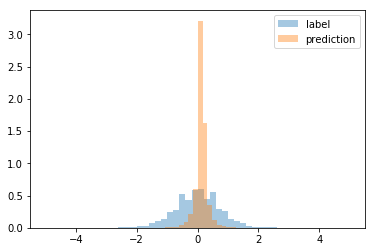

In [99]:
test_y_pred = model.predict(_train_x, batch_size=512, verbose=1)
sns.distplot(train_y, kde=False, norm_hist=True, label='label')
# sns.distplot(_test_y, kde=False, label='label smoothing')
sns.distplot(test_y_pred, kde=False, norm_hist=True, label='prediction')
plt.legend()
plt.show()

59999/59999 [==============================] - 1s 24us/step


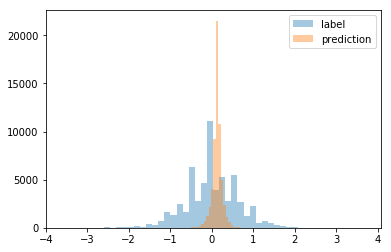

In [100]:
test_y_pred = model.predict(_val_x, batch_size=512, verbose=1)
sns.distplot(val_y, kde=False, label='label')
# sns.distplot(_test_y, kde=False, label='label smoothing')
sns.distplot(test_y_pred, kde=False, label='prediction')
plt.legend()
plt.show()

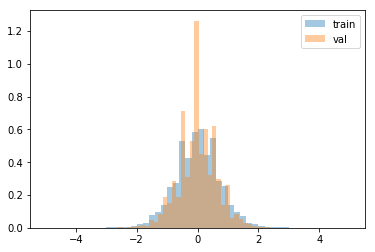

In [88]:
sns.distplot(train_y, kde=False, norm_hist=True, label='train')
sns.distplot(val_y, kde=False, norm_hist=True, label='val')
plt.legend()
plt.show()

In [50]:
score(train_y, _train_y)

0.8987584933638573

### 3.5 sign model

In [ ]:
sign_model = rate_size_fusion(time_step=time_step)
sign_model.compile(Adam(2e-4), loss='mse', metrics=['accuracy'])
history = sign_model.fit(rates_sizes_split(train_x), np.sign(train_y+1e-3), 
                    batch_size=512, epochs=20, 
                    validation_data=(rates_sizes_split(val_x), np.sign(val_y+1e-3)), 
                    callbacks=None)

### 3.6 deep_lob

In [26]:
def norm_y(mid_price):
    pass

def norm_y_to_label():
    pass

time_step = 10
mid_rate = (dataset.features[:, 0] + dataset.features[:, 30]) / 2
mid_rate = np.expand_dims(np.pad(mid_rate, (time_step-1, 0), 'edge'), axis=1)
mid_rate = dt.data_sliding(mid_rate, time_step=time_step)
mean_mid_rate = np.mean(mid_rate, axis=(1, 2))
# std_mid_rate = np.std(mid_rate, axis=(1, 2))

delay = 87
normed_y = mean_mid_rate[delay:] - mean_mid_rate[:-delay]

In [29]:
normed_y.shape

(2999461,)

In [17]:
dataset.features.shape

(2999548, 60)

In [51]:
time_step = 30
wsz = 10

normed_data = dt_norm.slide_norm(dataset.features, window_size=wsz)
_normed_data = normed_data[:, 0::15]
for i in range(1, 15):
    _normed_data = np.concatenate([_normed_data, normed_data[:,i::15]], axis=1)

x, y = dt.data_sliding(_normed_data, dataset.label_y, time_step=time_step*time_stride)
x = x[:, ::time_stride]
# (train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data_by_interval([x, y], split=[0.6, 0.2, 0.2], sampling=5)
# (train_x, train_y, train_mp), (val_x, val_y, val_mp), (test_x, test_y, test_mp) = dt.split_data([x, y, middle_price], split=[0.6, 0.1, 0.3], sampling=5)
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

train:359942, val:59990, test:179972


In [63]:
dlob_model = deep_lob(time_steps=time_step, nb_features=60, regression=True)
dlob_model.compile(Adam(2e-4), loss=tf_score)

In [65]:
history = dlob_model.fit(np.expand_dims(train_x, axis=3), train_y, batch_size=256, epochs=20, 
                         validation_data=(np.expand_dims(val_x, axis=3), val_y), callbacks=train_callbacks)
train_score, val_score, test_score = model_score(dlob_model, train_x, train_y, val_x, val_y, test_x, test_y)

Train on 359942 samples, validate on 59990 samples
Epoch 1/20
359942/359942 [==============================] - 134s 373us/step - loss: 0.9914 - val_loss: 0.9861
Epoch 2/20
359942/359942 [==============================] - 133s 368us/step - loss: 0.9847 - val_loss: 0.9833
Epoch 3/20
359942/359942 [==============================] - 132s 366us/step - loss: 0.9821 - val_loss: 0.9834
Epoch 4/20
359942/359942 [==============================] - 132s 366us/step - loss: 0.9796 - val_loss: 0.9876
Epoch 5/20
359942/359942 [==============================] - 132s 366us/step - loss: 0.9768 - val_loss: 0.9977

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00011999999696854502.
Epoch 6/20
359942/359942 [==============================] - 132s 366us/step - loss: 0.9718 - val_loss: 0.9990
Epoch 7/20
359942/359942 [==============================] - 131s 365us/step - loss: 0.9681 - val_loss: 1.0464
Epoch 8/20
359942/359942 [==============================] - 132s 366us/step - loss: 0.9638 - val_

ValueError: Error when checking input: expected input_1 to have shape (15, 60) but got array with shape (30, 60)

## 4. evaluation

### sign & mlp

In [ ]:
# value
train_y_pred = model.predict(rates_sizes_split(train_x), batch_size=512, verbose=1)
test_y_pred = model.predict(rates_sizes_split(test_x), batch_size=512, verbose=1)

# sign
train_pred_sign = sign_model.predict(rates_sizes_split(train_x), batch_size=512, verbose=1)
test_pred_sign = sign_model.predict(rates_sizes_split(train_x), batch_size=512, verbose=1)


In [213]:
train_score = score(train_y, train_y_pred[:, 0] * np.sign(np.random.rand(359998)-0.28) * np.sign(train_y+1e-3))
print('train score: {:.5f}'.format(train_score))


test_score = score(test_y, test_y_pred[:, 0] * np.sign(np.random.rand(180000)) * np.sign(test_y+1e-3))
print('test score: {:.5f}'.format(test_score))

359998/359998 [==============================] - 4s 11us/step
train score: 0.05142
180000/180000 [==============================] - 2s 11us/step
test score: 0.53956


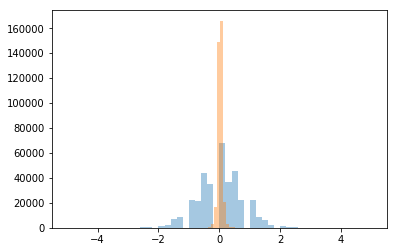

In [172]:
sns.distplot(train_y, kde=False)
sns.distplot(train_y_pred, kde=False)
plt.show()

In [156]:
train_score, test_score = model_score(model, rates_sizes_split(train_x), train_y, rates_sizes_split(test_x), test_y)

359998/359998 [==============================] - 8s 23us/step
train score: 0.05221
180000/180000 [==============================] - 4s 21us/step
test score: 0.00580


## matching

In [140]:
time_step = 120
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=time_step, norm_window_size=60)

train:359985, val:59998, test:179993


In [141]:
_train_x = np.copy(train_x[::5])
_train_y = np.copy(train_y[::5])
_train_x_pos = _train_x[_train_y > 0]
_train_x_neg = _train_x[_train_y < 0]

In [149]:
_trainx_rate_pos = np.concatenate([_train_x_pos[..., :15], _train_x_pos[..., 30:45]], axis=2).reshape((_train_x_pos.shape[0],-1))
_trainx_rate_neg = np.concatenate([_train_x_neg[..., :15], _train_x_neg[..., 30:45]], axis=2).reshape((_train_x_neg.shape[0],-1))

In [150]:
neg_score = np.dot(_trainx_rate_neg, _trainx_rate_neg[::10].transpose([1,0]))
pos_score = np.dot(_trainx_rate_pos, _trainx_rate_neg[::10].transpose([1,0]))

In [154]:
_trainx_rate_pos.shape

(29546, 3600)

In [152]:
mean_neg_score = np.mean(neg_score, axis=0)
mean_pos_score = np.mean(pos_score, axis=0)
np.sum(np.mean(neg_score, axis=0) > np.mean(pos_score, axis=0))

1450

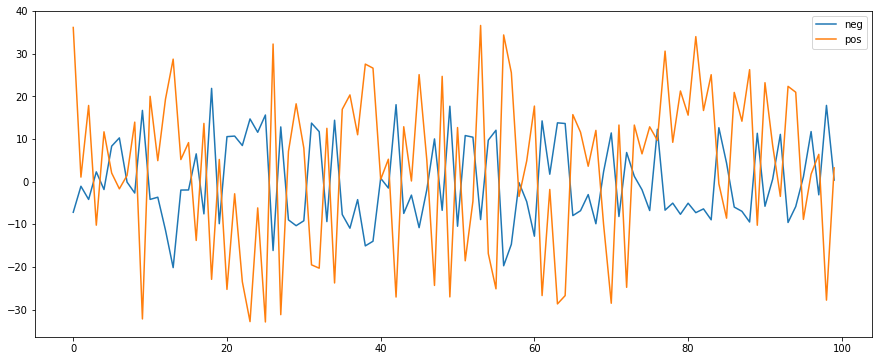

In [145]:
plt.rcParams['figure.figsize'] = (15.0, 6.0)
plt.plot(mean_neg_score[:100], label='neg')
plt.plot(mean_pos_score[:100], label='pos')
plt.legend()
plt.show()

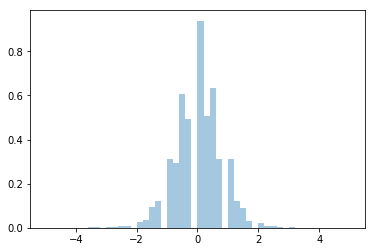

In [105]:
sns.distplot(train_y[::5], kde=False, norm_hist=True)
plt.show()

## hyper parameters search

In [ ]:
time_step = [5, 10, 20, 30, 60, 90, 120, 240, 360]
norm_window = [30, 60, 120, 360]
learning_rate = [2e-4, 3e-4, 5e-4, 8e-4, 1e-3]
